In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# Import Data

In [44]:
returns_no_rf = pd.read_csv('data/ff5_no_rf.csv')
returns_rf = pd.read_csv('data/ff5.csv')

# Data Pre-Processing

In [68]:
#returns_no_rf = returns_no_rf.set_index('Unnamed: 0')
returns_no_rf = returns_no_rf.rename_axis('Date', axis='index')
returns_no_rf.index = pd.to_datetime(returns_no_rf.index, format='%Y%m%d')
returns_no_rf

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1963-07-01,-0.0067,0.0002,-0.0035,0.0003,0.0013
1963-07-02,0.0079,-0.0028,0.0028,-0.0008,-0.0021
1963-07-03,0.0063,-0.0018,-0.0010,0.0013,-0.0025
1963-07-05,0.0040,0.0009,-0.0028,0.0007,-0.0030
1963-07-08,-0.0063,0.0007,-0.0020,-0.0027,0.0006
...,...,...,...,...,...
2022-12-23,0.0051,-0.0034,0.0115,0.0086,0.0046
2022-12-27,-0.0051,-0.0042,0.0142,0.0113,0.0121
2022-12-28,-0.0123,-0.0030,-0.0029,-0.0096,-0.0003


# Plot Cumulative Return of Each Factors

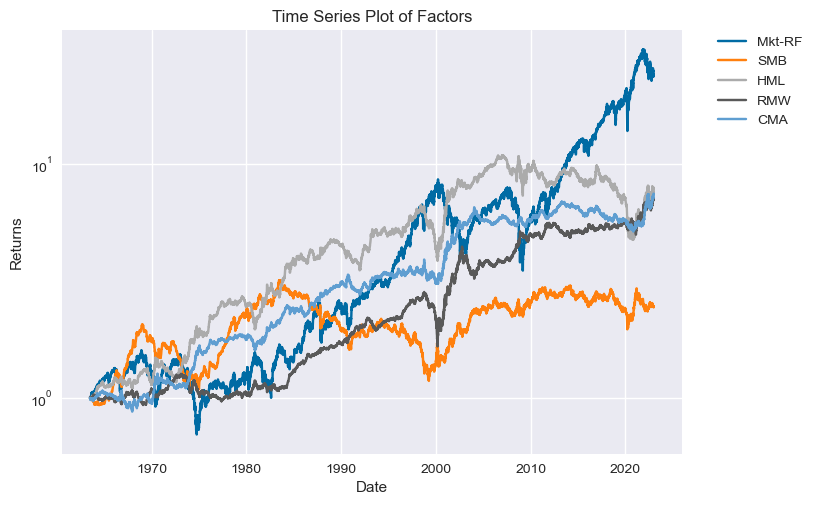

In [89]:
"""
https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
"""
columns = returns_no_rf.columns
cum_return = (returns_no_rf[columns] + 1).cumprod(axis=0)

plt.style.use('tableau-colorblind10')

plt.plot(cum_return, label=columns)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Time Series Plot of Factors')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.yscale('log')
plt.grid(True)
plt.show()

# Define Halflife Pairs
#### Specify the volatility halflife and covariance halflife for the EWMA

In [90]:
# provided
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - looks like the pairs are chosen to capture a variety of date ranges, from short term to 1 year
"""
rw_memory = 125   
ewma_halflife = 63
iewma_pair = (21,63)
cm_iewma_pairs = [(5, 10), (10, 21), (21, 63), (63, 125), (125, 250)]

# Compute IEWMA Covariance Matrices
#### For each halflife pairs, compute a series of IEWMA covariance matrices over time to produce multiple sets of covariance estimators. 

# Organizing Covariance Matrices
#### Nested dictionary for ease of access

# Regularization
#### Identify the fastest halflife pairs

# Combining Covariance Matrices
#### Combine the multiple covariance matrices into a single estimator (CM-IEWMA) by finding the optimal weight that minimizes loss

# Analyzing Weights
#### How does the combination weights for each halflife pair evolve over time? Which time scale is more influential?

# Evaluating Performance
#### Assess accuracy of CM-IEWMA estimator via MSE, log likelihood, and compare against MGARCH

# Portfolio Optimizaiton 
#### Construct a portfolio and evaluate the performance